In [1]:
%matplotlib inline

import argparse
import datetime
import json
import logging
import math
import os
import pickle
import time
from typing import Any, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.sparse as sparse
import torch
import torch.nn as nn
from torch.optim import Adam

U narednoj ćeliji se nalaze pomoćne funkcije i parametri koji će biti korišćeni u nastavku.

In [2]:
CORA_PARAMS = {
    "train_range": [0, 140],
    "val_range": [140, 640],
    "test_range": [1708, 2708],
    "num_features": 1433,
    "num_classes": 7
}


def generate_unique_name() -> str:
    """Generates (unique) name that is used for naming local runs.

    Returns:
        run_name (str): unique name.
    """
    run_name = datetime.datetime.utcnow().strftime("%y-%m-%d-%H-%M-%S-%f")

    return run_name


def make_dir_hierarchy() -> Dict[str, str]:
    """Creating all necessary directories that the current run will use.

    Returns:
        paths (argparse.Namespace): dictionary with created paths and other information.
    """
    run_name = generate_unique_name()

    # directory for storing information of current run
    runs_path = os.path.join("logs", run_name)
    os.makedirs(runs_path, exist_ok=True)

    # directory for storing log (including loss information)
    log_path = os.path.join(runs_path, "log")
    os.makedirs(log_path, exist_ok=True)

    # directory for storing checkpoints
    checkpoints_path = os.path.join(runs_path, "checkpoints")
    os.makedirs(checkpoints_path, exist_ok=True)

    paths = {
        "run_name": run_name,
        "runs_path": runs_path,
        "log_path": log_path,
        "checkpoints_path": checkpoints_path
    }

    return paths


def load_train_config(path: str) -> Dict[str, Any]:
    """Reads JSON config file and returns it.

    Args:
        path (str): config path.

    Returns:
        config (dict): config.
    """
    with open(path, "r") as f:
        config = json.load(f)

    return config


def read_from_binary(path: str):
    """Reads data from binary file.

    Args:
        path (str): path of the binary file.
    """
    with open(path, "rb") as f:
        data = pickle.load(f)

    return data


def normalize_features(features: Union[np.ndarray, sparse.csr.csr_matrix]):
    """Normalize each row to the unit row.

    Args:
        node_features (union): matrix of node features.

    Returns:
        node_features_normalized (union): normalized node features.
    """
    features_sum = np.array(np.sum(features, axis=1))

    features_inv_sum = np.squeeze(1.0 / features_sum)
    features_inv_sum[np.isinf(features_inv_sum)] = 1

    features_inv_sum_diag = sparse.diags(features_inv_sum)
    features_normalized = features_inv_sum_diag.dot(features)

    return features_normalized


def load_cora(data_dir: str, topology_normalization: str = None):
    """Loads CORA dataset.

    Args:
        data_dir (str): data directory.
        topology_normalization (str): how to normalize topology.

    Returns:
        node_features, node_labels, topology (tuple): pre-processed data.
    """
    # reading raw data
    node_features = read_from_binary(os.path.join(data_dir, "node_features.csr"))
    node_labels = read_from_binary(os.path.join(data_dir, "node_labels.npy"))
    adjacency_list = read_from_binary(os.path.join(data_dir, "adjacency_list.dict"))

    node_features = normalize_features(node_features)

    # making dense adjacency matrix ready for softmax to be applied
    topology = nx.adjacency_matrix(nx.from_dict_of_lists(adjacency_list))
    topology = topology.todense().astype(np.float32)
    # adding loops
    topology += np.identity(topology.shape[0])

    if topology_normalization == "softmax":
        # making topology ready for softmax (-np.inf -> 0; 0 -> 1)
        topology[topology == 0] = -np.inf
        topology[topology == 1] = 0
    elif topology_normalization == "unit":
        topology = normalize_features(topology)

    return node_features, node_labels, topology


def calc_accuracy(preds: torch.Tensor, labels: torch.Tensor) -> float:
    if len(preds.size()) == 2:
        preds = torch.argmax(preds, dim=1)
    elif len(preds.size()) > 2:
        raise RuntimeError("Invalid prediction shape")

    num_hits = torch.sum(preds == labels)
    accuracy = num_hits / labels.size(0)

    return accuracy

In [3]:
class DropoutWrapper(nn.Module):
    def __init__(self, fn: nn.Module, dropout_prob: float):
        super().__init__()

        self._fn = fn
        self._activation = nn.ReLU()
        self._dropout = nn.Dropout(dropout_prob)

    def forward(self, data):
        topology = data[1]
        output = self._fn(data)[0]
        output = self._dropout(self._activation(output))

        return output, topology


class GraphConvolution(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias=True):
        super().__init__()

        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter("bias", None)

        self._init_params()

    def _init_params(self):
        std = 1.0 / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-std, std)
        if self.bias is not None:
            self.bias.data.uniform_(-std, std)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]):
        x, topology = data
        support = torch.matmul(x, self.weight)
        output = torch.matmul(topology, support)

        if self.bias is not None:
            output += self.bias

        return output, topology


class GCN(nn.Module):
    def __init__(self, num_features_per_layer: List[int], dropout_prob: float):
        super().__init__()

        layers = []
        for prev, curr in zip(num_features_per_layer[:-1: 2], num_features_per_layer[1::2]):
            layers.append(DropoutWrapper(GraphConvolution(prev, curr), dropout_prob))
        layers.append(GraphConvolution(num_features_per_layer[-2], num_features_per_layer[-1]))

        self._net = nn.Sequential(*layers)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]):
        output = self._net(data)

        return output

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, intermediate_dim: List[int], output_dim: int):
        super().__init__()

        layers = []
        if len(intermediate_dim) == 0:
            layers.append(nn.Linear(input_dim, output_dim))
        else:
            num_neurons = [input_dim] + intermediate_dim
            for prev, curr in zip(num_neurons[:-1], num_neurons[1:]):
                layers.append(nn.Linear(prev, curr))
                layers.append(nn.GELU())

            layers.append(nn.Linear(num_neurons[-1], output_dim))

        self._net = nn.Sequential(*layers)
        self._softmax = nn.Softmax(dim=-1)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        x, topology = data
        output = self._net(x)
        output = self._softmax(output)

        return output, topology

In [5]:
class GATLayer(nn.Module):
    """Class for GAT's elementary layer."""

    def __init__(self, num_in_features: int, num_out_features: int, num_heads: int, dropout_prob: float = 0.6,
                 to_aggregate_heads: bool = False, add_skip_connection: bool = True):
        """Constructor of GAT layer.

        Args:
            num_in_features (int): number of input features.
            num_out_features (int): number of output features.
            num_heads (int): number of attention heads.
            dropout_prob (float): probability of dropout.
            to_aggregate_heads (bool): aggregate features of attention heads (True) or not (False).
            add_skip_connection (bool): to add (True) or not (False) residual/skip connection.
        """
        super().__init__()

        # head's dimension
        self._head_dim = 1
        self._num_in_features = num_in_features
        self._num_out_features = num_out_features
        self._num_heads = num_heads
        self._to_aggregate_heads = to_aggregate_heads
        self._add_skip_connection = add_skip_connection

        # not used during training - only for logging/visualization
        self._attention_weights = None

        # projection and scoring mappings
        self._proj_param = nn.Parameter(torch.Tensor(num_heads, num_in_features, num_out_features))
        self._scoring_source = nn.Parameter(torch.Tensor(num_heads, num_out_features, 1))
        self._scoring_target = nn.Parameter(torch.Tensor(num_heads, num_out_features, 1))

        if add_skip_connection:
            self._skip_proj = nn.Linear(num_in_features, num_heads * num_out_features, bias=False)

        self._activation = nn.LeakyReLU(negative_slope=0.2)
        self._softmax = nn.Softmax(dim=-1)
        self._dropout = nn.Dropout(p=dropout_prob)

        self._init_params()

    def _init_params(self):
        nn.init.xavier_uniform_(self._proj_param)
        nn.init.xavier_uniform_(self._scoring_source)
        nn.init.xavier_uniform_(self._scoring_target)

    def _aggregate_heads(self, attention_weights: torch.Tensor, in_node_features: torch.Tensor, out_node_features: torch.Tensor) \
            -> torch.Tensor:
        """Aggregate features of all attention heads.

        Aggregation is either cocatenation or mean.

        Args:
            attention_weights (torch.Tensor): attention coefficients.
            in_node_features (torch.Tensor): input node features.
            out_node_features (torch.Tensor): output node features.

        Returns:
            out_node_features (torch.Tensor): aggregated node features.
        """
        # for later inspection
        self._attention_weights = attention_weights

        # view will raise an exception if underlying memory isn't contiguous
        if not out_node_features.is_contiguous():
            out_node_features = out_node_features.contiguous()

        if self._add_skip_connection:
            if out_node_features.size(-1) == in_node_features.size(-1):
                out_node_features += in_node_features.unsqueeze(1)
            else:
                out_node_features += self._skip_proj(in_node_features).view(-1, self._num_heads, self._num_out_features)

        if self._to_aggregate_heads:
            out_node_features = out_node_features.view(-1, self._num_heads * self._num_out_features)
        else:
            out_node_features = torch.mean(out_node_features, dim=self._head_dim)

        out_node_features = self._activation(out_node_features)

        return out_node_features

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass.

        Input needs to be fed as a tuple because GAT is defined as a sequential model.

        Args:
            data (tuple): input node features and graph topology.

        Returns:
            out_node_features, topology (tuple): output node features and graph topology.
        """
        in_node_features, topology = data
        num_nodes = in_node_features.shape[0]
        assert topology.shape == (num_nodes, num_nodes), "Adjacency matrix has invalid shape."

        in_node_features = self._dropout(in_node_features)
        node_features_proj = torch.matmul(in_node_features.unsqueeze(0), self._proj_param)
        node_features_proj = self._dropout(node_features_proj)

        edge_scores_source = torch.bmm(node_features_proj, self._scoring_source)
        edge_scores_target = torch.bmm(node_features_proj, self._scoring_target)
        edge_scores = self._activation(edge_scores_source + edge_scores_target.transpose(1, 2))
        attention_weights = self._softmax(edge_scores + topology)

        out_node_features = torch.bmm(attention_weights, node_features_proj)
        out_node_features = out_node_features.transpose(0, 1)

        out_node_features = self._aggregate_heads(attention_weights, in_node_features, out_node_features)

        return out_node_features, topology


class GAT(nn.Module):
    """Class for Graph Attention Network (GAT)."""

    def __init__(self, num_heads_per_layer: List[int], num_features_per_layer: List[int], dropout_prob: float = 0.6,
                 add_skip_connection: bool = True, **kwargs):
        """Constructor of GAT.

        Args:
            num_heads_per_layer (list): number of heads for each layer.
            num_features_per_layer (list): number of features for each layer.
            dropout_prob (float): probability of dropout layer used in GAT's layers.
            add_skip_connection (bool): to add (True) or not (False) residual/skip connection.
        """
        super().__init__()

        num_layers = len(num_heads_per_layer)
        num_heads_per_layer = [1] + num_heads_per_layer

        layers = []
        for i in range(num_layers):
            layer = GATLayer(num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],
                             num_out_features=num_features_per_layer[i + 1],
                             num_heads=num_heads_per_layer[i + 1],
                             to_aggregate_heads=i < num_layers - 1,
                             dropout_prob=dropout_prob,
                             add_skip_connection=add_skip_connection)
            layers.append(layer)

        self._net = nn.Sequential(*layers)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass.

        Input needs to be fed as a tuple because GAT is defined as a sequential model.

        Args:
            data (tuple): input node features and graph topology.

        Returns:
            output (tuple): output node features and graph topology.
        """
        output = self._net(data)

        return output

Predstoji klasa namenjena enkapsulaciji treninga. Kreiraće model na osnovu prosleđene konfiguracije i vršiti detaljni prikaz rezultata (funkcije gubitka i tačnosti).

In [6]:
class Trainer:
    """Class used for training the GAT."""

    def __init__(self, config: Dict[str, Any]):
        """Constructor.

        Args:
            config (dict): configuration of the training, inference and the model.
        """
        self._paths = make_dir_hierarchy()
        self._setup_logger(os.path.join(self._paths["log_path"], "log.txt"))

        with open(os.path.join(self._paths["runs_path"], "config.json"), "w") as f:
            json.dump(config, f, indent=4)

        self._config = config
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        topology_normalization = "unit" if config["model_name"] == "GCN" else "softmax"
        node_features, node_labels, topology = load_cora(config["data_dir"], topology_normalization)
        self._node_features = torch.tensor(node_features.todense(), device=self._device)
        self._node_labels = torch.tensor(node_labels, dtype=torch.long, device=self._device)
        self._topology = torch.tensor(topology, dtype=torch.float32, device=self._device)
        self._indices = {
            "train": torch.arange(*CORA_PARAMS["train_range"], dtype=torch.long, device=self._device),
            "val": torch.arange(*CORA_PARAMS["val_range"], dtype=torch.long, device=self._device),
            "test": torch.arange(*CORA_PARAMS["test_range"], dtype=torch.long, device=self._device)
        }

        if config["model_name"] == "GCN":
            self._model = GCN(**config["model_kwargs"]).to(self._device)
        elif config["model_name"] == "GAT":
            self._model = GAT(**config["model_kwargs"]).to(self._device)
        elif config["model_name"] == "MLP":
            self._model = MLP(**config["model_kwargs"]).to(self._device)

        self._criterion = nn.CrossEntropyLoss()
        self._optimizer = Adam(self._model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

        # saves all metrics and losses during training
        self._aggregator = {}

    def _update_aggregator(self, name: str, value: float) -> None:
        aggregated_values = self._aggregator.get(name, [])
        aggregated_values.append(value)
        self._aggregator[name] = aggregated_values

    def _setup_logger(self, log_path: str) -> None:
        """Setup logging to print logs to both file and stdout.

        Timestamps are in GMT format due to lexicographic order. Example: 22-01-27-21-09-48.

        Args:
            log_path (str): path of log file.
        """
        logging.basicConfig(
            level=logging.INFO,
            format="%(asctime)s: [%(levelname)s] %(message)s",
            datefmt="%y-%m-%d %H:%M:%S",
            handlers=[
                logging.FileHandler(log_path),
                logging.StreamHandler()
            ]
        )
        logging.Formatter.converter = time.gmtime

    def _prepare_log(self, epoch, ce, acc, name):
        epoch_length = len(str(self._config["epochs"]))
        total_length = len(f"epoch=[{self._config['epochs']}/{self._config['epochs']}]:")
        epoch_log = f"epoch=[{epoch:>{epoch_length}}/{self._config['epochs']}]:"
        ce_log = f"CE_{name}={ce:.5f}"
        acc_log = f"ACC_{name}={acc:.2%}"
        log = f"{epoch_log:<{total_length}} {ce_log:>16} {acc_log:>16}"

        return log

    def run_training(self):
        train_labels = self._node_labels.index_select(0, self._indices["train"])
        train_indices = self._indices["train"]
        graph_data = (self._node_features, self._topology)

        for epoch in range(1, self._config["epochs"] + 1):
            self._model.train()
            self._optimizer.zero_grad()

            pred_labels = self._model(graph_data)[0].index_select(0, train_indices)
            loss = self._criterion(pred_labels, train_labels)
            accuracy = calc_accuracy(pred_labels, train_labels)

            logging.info(self._prepare_log(epoch, loss.item(), accuracy, "train"))
            self._update_aggregator("CE_train", (epoch, loss.item()))
            self._update_aggregator("ACC_train", (epoch, accuracy))

            loss.backward()
            self._optimizer.step()

            if epoch % self._config["ckpt_freq"] == 0:
                self._dump_model(epoch)

            if epoch == 1 or epoch % self._config["val_freq"] == 0:
                self._run_val(epoch)

            if epoch == 1 or epoch % self._config["test_freq"] == 0:
                self._run_test(epoch)

    def _run_val(self, epoch: int):
        val_labels = self._node_labels.index_select(0, self._indices["val"])
        val_indices = self._indices["val"]
        graph_data = (self._node_features, self._topology)

        self._model.eval()
        pred_labels = self._model(graph_data)[0].index_select(0, val_indices)
        loss = self._criterion(pred_labels, val_labels)
        accuracy = calc_accuracy(pred_labels, val_labels)

        logging.info(self._prepare_log(epoch, loss.item(), accuracy, "val"))
        self._update_aggregator("CE_val", (epoch, loss.item()))
        self._update_aggregator("ACC_val", (epoch, accuracy))

    def _run_test(self, epoch: int):
        test_labels = self._node_labels.index_select(0, self._indices["test"])
        test_indices = self._indices["test"]
        graph_data = (self._node_features, self._topology)

        self._model.eval()
        pred_labels = self._model(graph_data)[0].index_select(0, test_indices)
        loss = self._criterion(pred_labels, test_labels)
        accuracy = calc_accuracy(pred_labels, test_labels)

        logging.info(self._prepare_log(epoch, loss.item(), accuracy, "test"))
        self._update_aggregator("CE_test", (epoch, loss.item()))
        self._update_aggregator("ACC_test", (epoch, accuracy))

    def _dump_model(self, epoch: int) -> None:
        """Dumps current checkpoint.

        Args:
            epoch (int): current epoch.
        """
        ckpt_path = os.path.join(self._paths["checkpoints_path"], f"gat_{epoch}.ckpt")
        torch.save(self._model.state_dict(), ckpt_path)

    @property
    def aggregator(self) -> Dict[str, Any]:
        """Getter for aggregator."""
        return self._aggregator

    @property
    def model(self) -> nn.Module:
        """Getter for model."""
        return self._model

    @property
    def device(self) -> torch.device:
        """Getter for device."""
        return self._device

# Treniranje modela

Obučićemo prethodno definisane modele i potom ih analizirati. U pitanju su višelojni perceptron, grafovska konvolutivna mreža i grafovska mreža sa mehanizmom pažnje.

In [7]:
config_gcn = {
    "model_name": "GCN",
    "data_dir": "data",
    "epochs": 200,
    "lr": 0.01,
    "weight_decay": 0.0005,
    "model_kwargs": {
        "num_features_per_layer": [1433, 16, 7],
        "dropout_prob": 0.5
    },
    "ckpt_freq": 100,
    "val_freq": 10,
    "test_freq": 10
}

trainer_gcn = Trainer(config_gcn)
trainer_gcn.run_training()

C:\Users\kostag\Anaconda3\envs\mlmatf-gnn\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
22-06-17 21:31:01: [INFO] epoch=[  1/200]: CE_train=1.96911 ACC_train=12.86%
22-06-17 21:31:01: [INFO] epoch=[  1/200]:   CE_val=2.00498   ACC_val=10.00%
22-06-17 21:31:01: [INFO] epoch=[  1/200]:  CE_test=2.00148   ACC_test=8.00%
22-06-17 21:31:01: [INFO] epoch=[  2/200]: CE_train=1.96602 ACC_train=12.86%
22-06-17 21:31:01: [INFO] epoch=[  3/200]: CE_train=1.95915 ACC_train=15.00%
22-06-17 21:31:01: [INFO] epoch=[  4/200]: CE_train=1.95614 ACC_train=15.71%
22-06-17 21:31:01: [INFO] epoch=[  5/200]: CE_train=1.94874 ACC_train=15.71%
22-06-17 21:31:01: [INFO] epoch=[  6/200]: CE_train=1.94266 ACC_train=17.86%
22-06-

22-06-17 21:31:03: [INFO] epoch=[ 85/200]: CE_train=0.81844 ACC_train=90.71%
22-06-17 21:31:03: [INFO] epoch=[ 86/200]: CE_train=0.81275 ACC_train=91.43%
22-06-17 21:31:03: [INFO] epoch=[ 87/200]: CE_train=0.87019 ACC_train=91.43%
22-06-17 21:31:03: [INFO] epoch=[ 88/200]: CE_train=0.83997 ACC_train=88.57%
22-06-17 21:31:04: [INFO] epoch=[ 89/200]: CE_train=0.79860 ACC_train=88.57%
22-06-17 21:31:04: [INFO] epoch=[ 90/200]: CE_train=0.77982 ACC_train=93.57%
22-06-17 21:31:04: [INFO] epoch=[ 90/200]:   CE_val=1.10688   ACC_val=79.00%
22-06-17 21:31:04: [INFO] epoch=[ 90/200]:  CE_test=1.08542  ACC_test=80.90%
22-06-17 21:31:04: [INFO] epoch=[ 91/200]: CE_train=0.74371 ACC_train=92.14%
22-06-17 21:31:04: [INFO] epoch=[ 92/200]: CE_train=0.77301 ACC_train=87.86%
22-06-17 21:31:04: [INFO] epoch=[ 93/200]: CE_train=0.73926 ACC_train=92.86%
22-06-17 21:31:04: [INFO] epoch=[ 94/200]: CE_train=0.75108 ACC_train=93.57%
22-06-17 21:31:04: [INFO] epoch=[ 95/200]: CE_train=0.70680 ACC_train=92.14%

22-06-17 21:31:06: [INFO] epoch=[174/200]: CE_train=0.35424 ACC_train=95.71%
22-06-17 21:31:06: [INFO] epoch=[175/200]: CE_train=0.34699 ACC_train=98.57%
22-06-17 21:31:06: [INFO] epoch=[176/200]: CE_train=0.39262 ACC_train=95.71%
22-06-17 21:31:06: [INFO] epoch=[177/200]: CE_train=0.37129 ACC_train=95.71%
22-06-17 21:31:06: [INFO] epoch=[178/200]: CE_train=0.32223 ACC_train=96.43%
22-06-17 21:31:06: [INFO] epoch=[179/200]: CE_train=0.32348 ACC_train=97.86%
22-06-17 21:31:06: [INFO] epoch=[180/200]: CE_train=0.35006 ACC_train=96.43%
22-06-17 21:31:06: [INFO] epoch=[180/200]:   CE_val=0.76767   ACC_val=78.60%
22-06-17 21:31:06: [INFO] epoch=[180/200]:  CE_test=0.73685  ACC_test=80.80%
22-06-17 21:31:06: [INFO] epoch=[181/200]: CE_train=0.40093 ACC_train=94.29%
22-06-17 21:31:06: [INFO] epoch=[182/200]: CE_train=0.36460 ACC_train=95.71%
22-06-17 21:31:06: [INFO] epoch=[183/200]: CE_train=0.34063 ACC_train=97.86%
22-06-17 21:31:06: [INFO] epoch=[184/200]: CE_train=0.37299 ACC_train=97.86%

In [8]:
config_gat = {
    "model_name": "GAT",
    "data_dir": "data",
    "epochs": 200,
    "lr": 0.005,
    "weight_decay": 0.0005,
    "model_kwargs": {
        "num_heads_per_layer": [8, 1],
        "add_skip_connection": False,
        "num_features_per_layer": [1433, 8, 7],
        "dropout_prob": 0.6
    },
    "ckpt_freq": 100,
    "val_freq": 10,
    "test_freq": 10
}

trainer_gat = Trainer(config_gat)
trainer_gat.run_training()

22-06-17 21:31:08: [INFO] epoch=[  1/200]: CE_train=1.94603  ACC_train=7.14%
22-06-17 21:31:08: [INFO] epoch=[  1/200]:   CE_val=1.94546   ACC_val=47.00%
22-06-17 21:31:09: [INFO] epoch=[  1/200]:  CE_test=1.94546  ACC_test=46.10%
22-06-17 21:31:09: [INFO] epoch=[  2/200]: CE_train=1.94525 ACC_train=32.86%
22-06-17 21:31:10: [INFO] epoch=[  3/200]: CE_train=1.94442 ACC_train=42.86%
22-06-17 21:31:11: [INFO] epoch=[  4/200]: CE_train=1.94299 ACC_train=55.71%
22-06-17 21:31:11: [INFO] epoch=[  5/200]: CE_train=1.94176 ACC_train=57.86%
22-06-17 21:31:12: [INFO] epoch=[  6/200]: CE_train=1.94086 ACC_train=53.57%
22-06-17 21:31:13: [INFO] epoch=[  7/200]: CE_train=1.93893 ACC_train=56.43%
22-06-17 21:31:14: [INFO] epoch=[  8/200]: CE_train=1.93704 ACC_train=62.14%
22-06-17 21:31:14: [INFO] epoch=[  9/200]: CE_train=1.93630 ACC_train=59.29%
22-06-17 21:31:15: [INFO] epoch=[ 10/200]: CE_train=1.93229 ACC_train=65.00%
22-06-17 21:31:16: [INFO] epoch=[ 10/200]:   CE_val=1.93376   ACC_val=78.80%

22-06-17 21:32:21: [INFO] epoch=[ 90/200]: CE_train=1.07260 ACC_train=72.14%
22-06-17 21:32:22: [INFO] epoch=[ 90/200]:   CE_val=1.43818   ACC_val=80.00%
22-06-17 21:32:22: [INFO] epoch=[ 90/200]:  CE_test=1.41705  ACC_test=80.00%
22-06-17 21:32:23: [INFO] epoch=[ 91/200]: CE_train=1.14067 ACC_train=72.14%
22-06-17 21:32:24: [INFO] epoch=[ 92/200]: CE_train=0.99247 ACC_train=70.71%
22-06-17 21:32:24: [INFO] epoch=[ 93/200]: CE_train=1.00311 ACC_train=70.00%
22-06-17 21:32:25: [INFO] epoch=[ 94/200]: CE_train=1.16347 ACC_train=67.14%
22-06-17 21:32:26: [INFO] epoch=[ 95/200]: CE_train=1.08215 ACC_train=65.71%
22-06-17 21:32:27: [INFO] epoch=[ 96/200]: CE_train=1.07663 ACC_train=69.29%
22-06-17 21:32:27: [INFO] epoch=[ 97/200]: CE_train=1.14633 ACC_train=62.14%
22-06-17 21:32:28: [INFO] epoch=[ 98/200]: CE_train=1.12371 ACC_train=70.71%
22-06-17 21:32:29: [INFO] epoch=[ 99/200]: CE_train=0.99689 ACC_train=75.00%
22-06-17 21:32:29: [INFO] epoch=[100/200]: CE_train=1.17603 ACC_train=65.71%

22-06-17 21:33:33: [INFO] epoch=[179/200]: CE_train=0.98183 ACC_train=67.14%
22-06-17 21:33:34: [INFO] epoch=[180/200]: CE_train=0.77842 ACC_train=76.43%
22-06-17 21:33:35: [INFO] epoch=[180/200]:   CE_val=1.22167   ACC_val=80.40%
22-06-17 21:33:35: [INFO] epoch=[180/200]:  CE_test=1.19453  ACC_test=82.00%
22-06-17 21:33:35: [INFO] epoch=[181/200]: CE_train=0.78363 ACC_train=73.57%
22-06-17 21:33:36: [INFO] epoch=[182/200]: CE_train=0.83758 ACC_train=74.29%
22-06-17 21:33:37: [INFO] epoch=[183/200]: CE_train=0.75063 ACC_train=78.57%
22-06-17 21:33:38: [INFO] epoch=[184/200]: CE_train=0.79088 ACC_train=72.86%
22-06-17 21:33:38: [INFO] epoch=[185/200]: CE_train=0.61761 ACC_train=81.43%
22-06-17 21:33:39: [INFO] epoch=[186/200]: CE_train=0.79796 ACC_train=77.14%
22-06-17 21:33:40: [INFO] epoch=[187/200]: CE_train=0.84085 ACC_train=73.57%
22-06-17 21:33:41: [INFO] epoch=[188/200]: CE_train=0.73210 ACC_train=75.71%
22-06-17 21:33:41: [INFO] epoch=[189/200]: CE_train=0.76152 ACC_train=77.86%

In [9]:
config_mlp = {
    "model_name": "MLP",
    "data_dir": "data",
    "epochs": 100,
    "lr": 0.01,
    "weight_decay": 0.0005,
    "model_kwargs": {
        "input_dim": 1433,
        "intermediate_dim": [4096],
        "output_dim": 7
    },
    "ckpt_freq": 100,
    "val_freq": 10,
    "test_freq": 10
}

trainer_mlp = Trainer(config_mlp)
trainer_mlp.run_training()

22-06-17 21:33:52: [INFO] epoch=[  1/100]: CE_train=1.94591 ACC_train=14.29%
22-06-17 21:33:52: [INFO] epoch=[  1/100]:   CE_val=1.94594   ACC_val=18.60%
22-06-17 21:33:53: [INFO] epoch=[  1/100]:  CE_test=1.94589  ACC_test=20.00%
22-06-17 21:33:53: [INFO] epoch=[  2/100]: CE_train=1.94440 ACC_train=50.00%
22-06-17 21:33:54: [INFO] epoch=[  3/100]: CE_train=1.94325 ACC_train=37.86%
22-06-17 21:33:55: [INFO] epoch=[  4/100]: CE_train=1.94032 ACC_train=24.29%
22-06-17 21:33:55: [INFO] epoch=[  5/100]: CE_train=1.93401 ACC_train=17.14%
22-06-17 21:33:56: [INFO] epoch=[  6/100]: CE_train=1.92274 ACC_train=17.14%
22-06-17 21:33:57: [INFO] epoch=[  7/100]: CE_train=1.90425 ACC_train=27.86%
22-06-17 21:33:58: [INFO] epoch=[  8/100]: CE_train=1.87817 ACC_train=37.86%
22-06-17 21:33:58: [INFO] epoch=[  9/100]: CE_train=1.84633 ACC_train=43.57%
22-06-17 21:33:59: [INFO] epoch=[ 10/100]: CE_train=1.81087 ACC_train=43.57%
22-06-17 21:34:00: [INFO] epoch=[ 10/100]:   CE_val=1.91296   ACC_val=32.80%

22-06-17 21:35:06: [INFO] epoch=[ 90/100]: CE_train=1.49948 ACC_train=71.43%
22-06-17 21:35:07: [INFO] epoch=[ 90/100]:   CE_val=1.78179   ACC_val=52.40%
22-06-17 21:35:07: [INFO] epoch=[ 90/100]:  CE_test=1.76134  ACC_test=52.10%
22-06-17 21:35:07: [INFO] epoch=[ 91/100]: CE_train=1.49994 ACC_train=71.43%
22-06-17 21:35:08: [INFO] epoch=[ 92/100]: CE_train=1.49943 ACC_train=71.43%
22-06-17 21:35:09: [INFO] epoch=[ 93/100]: CE_train=1.49927 ACC_train=71.43%
22-06-17 21:35:10: [INFO] epoch=[ 94/100]: CE_train=1.49967 ACC_train=71.43%
22-06-17 21:35:11: [INFO] epoch=[ 95/100]: CE_train=1.49897 ACC_train=71.43%
22-06-17 21:35:11: [INFO] epoch=[ 96/100]: CE_train=1.49913 ACC_train=71.43%
22-06-17 21:35:12: [INFO] epoch=[ 97/100]: CE_train=1.49908 ACC_train=71.43%
22-06-17 21:35:13: [INFO] epoch=[ 98/100]: CE_train=1.49856 ACC_train=71.43%
22-06-17 21:35:14: [INFO] epoch=[ 99/100]: CE_train=1.49876 ACC_train=71.43%
22-06-17 21:35:15: [INFO] epoch=[100/100]: CE_train=1.49861 ACC_train=71.43%

In [10]:
def plot_metrics(aggregator: Dict[str, List[Tuple[float, float]]], metric_name: str, axis):
    metric_name = metric_name.upper()
    suffixes = ["train", "val", "test"]
    colors = ["blue", "green", "red"]

    for suffix, color in zip(suffixes, colors):
        name = f"{metric_name}_{suffix}"
        metric_values = aggregator[name]
        x_coords = list(map(lambda p: p[0], metric_values))
        y_coords = list(map(lambda p: p[1], metric_values))

        axis.plot(x_coords, y_coords, label=suffix, color=color)

    axis.legend(loc="upper right")
    axis.set_title(metric_name)
    axis.grid()

Prikaz funkcije gubitka i tačnosti tokom treninga, validacije i testa.

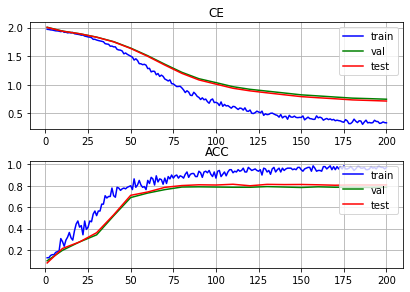

In [11]:
aggregator = trainer_gcn.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])

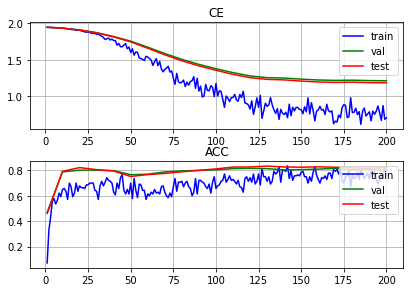

In [12]:
aggregator = trainer_gat.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])

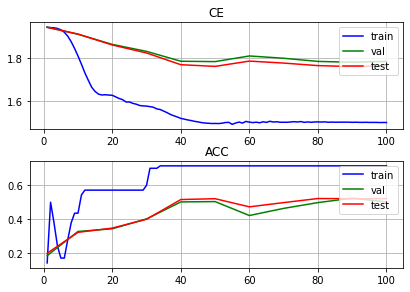

In [13]:
aggregator = trainer_mlp.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])

Na osnovu prikazanih grafika i metrika, možemo primetiti da je MLP ubedljivo najlošiji. Takođe, ne postoji statistički značajna razlika između GAT-a i GCN-a. Evidentan je manji šum u treningu kod GCN-a, kao i primetno preprilagođenje.

# Topološka analiza rezultata

Nakon što smo istrenirali GAT model, možemo izvršiti različite vizuelizacije iz kojih ćemo izvesti korisne zaključke.
Prikazaćemo ih ukupno tri:
1. Vizuelizacija podataka u skrivenom prostoru GAT modela, koristeći t-SNE (**t-distributed Stochastic Neighbor Embedding**),
2. Vizuelizacija podataka u skrivenom prostoru GAT modela, koristeći nešto noviji algoritam po imenu UMAP (**Uniform Manifold Approximation and Projection**) i
3. Vizuelizacija vrednosti koeficijenata pažnje pomoću entropije, pri čemu će biti upoređeni sa ravnomernom raspodelom.

t-SNE i UMAP su algoritmi za smanjivanje dimenzija podataka koji se oslanjaju na algebarsku topologiju prilikom analize podataka, određujući utapanje koje čuva topologiju. 

U izlaznom sloju prostoru GAT modela svaki čvor ima 7 atributa (jer imamo 7 različitih klasa), pa je cilj da, koristeći t-SNE i UMAP, preslikamo prostor $\mathbb{R}^7$ u $\mathbb{R}^2$ koji značajno lakše možemo da prikažemo.

GAT model sa jednakim koeficijentima pažnje se može tumačiti kao obična konvolutivna grafovska mreža. Odnosno skup modela grafovske konvolutivne mreže se može smatrati podskupom skupa GAT modela. Zato je ideja da pomoću treće i četvrte vizualizacija uporedimo koliko se raspodela koeficijenata pažnje razlikuje od uniformne raspodele. Što se više razlikuje, to se GAT model više razlikuje od konvolutivne grafovske mreže.

In [14]:
from sklearn.manifold import TSNE
from scipy.stats import entropy
import umap.umap_ as umap

Prvo ćemo definisati pomoćnu funkciju čiji je ulaz objekat klase Trainer, a izlazne vrednosti su vrednosti atributa pre primene softmax funkcije u poslednjem skrivenom sloju, skup grana grafa, labele čvorova i GAT model.

In [15]:
def gat_forward_pass(trainer):
    device = trainer.device

    gat = trainer.model
    node_features = trainer._node_features
    node_labels = trainer._node_labels
    topology = trainer._topology
    gat.eval()
    
    with torch.no_grad():
        # run predictions and collect the data before softmax
        all_nodes_unnormalized_scores, _ = gat((node_features, topology))
        all_nodes_unnormalized_scores = all_nodes_unnormalized_scores.cpu().numpy()
        
    return all_nodes_unnormalized_scores, topology, node_labels, gat

Zatim imamo i pomoćnu funkciju za iscrtavanje histograma. Hoćemo da iscrtamo histograme za vrednosti koeficijente pažnje i za ravnomernu raspodelu, pa taj izbor pravimo pomoću parametra `uniform_distribution`.

In [16]:
def draw_entropy_histogram(entropy_array, title, color="blue", uniform_distribution=False, num_bins=30):
    max_value = np.max(entropy_array)
    bar_width = (max_value / num_bins) * (1.0 if uniform_distribution else 0.75)
    histogram_values, histogram_bins = np.histogram(entropy_array, bins=num_bins, range=(0.0, max_value))

    plt.bar(histogram_bins[:num_bins], histogram_values[:num_bins], width=bar_width, color=color)
    plt.xlabel(f"entropy bins")
    plt.ylabel(f"# of node neighborhoods")
    plt.title(title)

Konačno, definišemo glavnu funkciju za vizuelizaciju modela. Pomoću parametra `visualization_type` biramo tip vizualizacije (t-SNE, UMAP ili entropija).

In [17]:
def visualize_gat_properties(trainer, visualization_type):
    all_nodes_unnormalized_scores, topology, node_labels, gat = gat_forward_pass(trainer)
    node_labels = node_labels.cpu().numpy()
    num_classes = CORA_PARAMS["num_classes"]
    
    if visualization_type == "tsne":
        # showing t-SNE in 2D embedding space
        t_sne_embeddings = TSNE(n_components=2, perplexity=30).fit_transform(all_nodes_unnormalized_scores)

        fig = plt.figure(figsize=(12,8), dpi=100)  
        for class_id in range(num_classes):
            # We extract the points whose true label equals class_id and we color them in the same way
            plt.scatter(t_sne_embeddings[node_labels == class_id, 0], 
                        t_sne_embeddings[node_labels == class_id, 1],
                        s=20, color={0: "yellow", 1: "red", 2: "green", 3: "orange",
                                     4: "pink", 5: "blue", 6: "gray"}[class_id], edgecolors='black', linewidths=0.2)
        plt.show()
    elif visualization_type == "umap":
        umap_embeddings = umap.UMAP(n_components=2).fit_transform(all_nodes_unnormalized_scores)

        fig = plt.figure(figsize=(12,8), dpi=100)  
        for class_id in range(num_classes):
            # We extract the points whose true label equals class_id and we color them in the same way
            plt.scatter(umap_embeddings[node_labels == class_id, 0],
                        umap_embeddings[node_labels == class_id, 1], s=20, 
                        color={0: "yellow", 1: "red", 2: "green", 3: "orange",
                               4: "pink", 5: "blue", 6: "gray"}[class_id], edgecolors='black', linewidths=0.2)
        plt.show()
    elif visualization_type == "entropy":
        num_heads_per_layer = [layer._num_heads for layer in gat._net]
        num_layers = len(num_heads_per_layer)

        _, _, topology = load_cora(config_gat["data_dir"])

        num_of_nodes = len(node_labels)
        for layer_id in range(num_layers):
            all_attentions = gat._net[layer_id]._attention_weights.cpu().numpy()

            for head_id in range(num_heads_per_layer[layer_id]):
                head_attentions = all_attentions[head_id]
                uniform_dist_entropy_list = []  # save the ideal uniform histogram as the reference
                neighborhood_entropy_list = []

                for target_node_id in range(num_of_nodes):
                    # finding neighborhood of the target node
                    neighborhood = np.nonzero(topology[:, target_node_id])
                    neighborhood_attentions = head_attentions[neighborhood, target_node_id].flatten()
                    ideal_uniform_attention = np.ones(len(neighborhood_attentions)) / len(neighborhood_attentions)

                    neighborhood_entropy_list.append(entropy(neighborhood_attentions, base=2))
                    uniform_dist_entropy_list.append(entropy(ideal_uniform_attention, base=2))

                title = f"Cora entropy histogram layer={layer_id}, attention head={head_id}"
                draw_entropy_histogram(uniform_dist_entropy_list, title, color="darkseagreen", uniform_distribution=True)
                draw_entropy_histogram(neighborhood_entropy_list, title, color="crimson")
                plt.show()
                plt.close()

Prvo ćemo vizualizovati podatke koristeći t-SNE, a zatim UMAP.

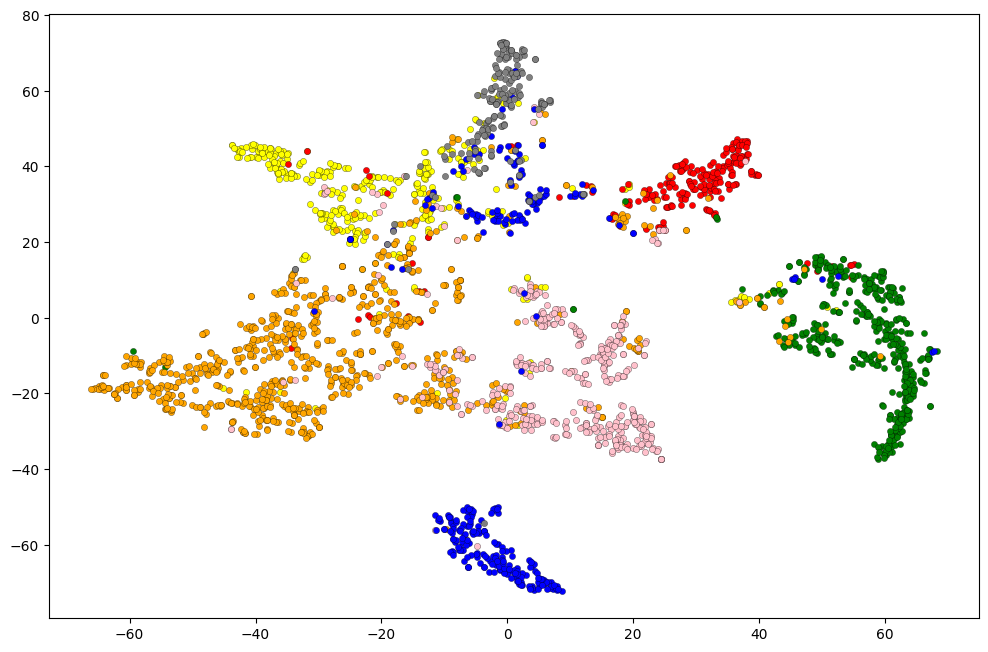

In [18]:
visualize_gat_properties(trainer_gat, visualization_type="tsne")

Sa grafika vidimo da je naš model odradio odličan posao - možemo jasno uočiti sedam klastera.

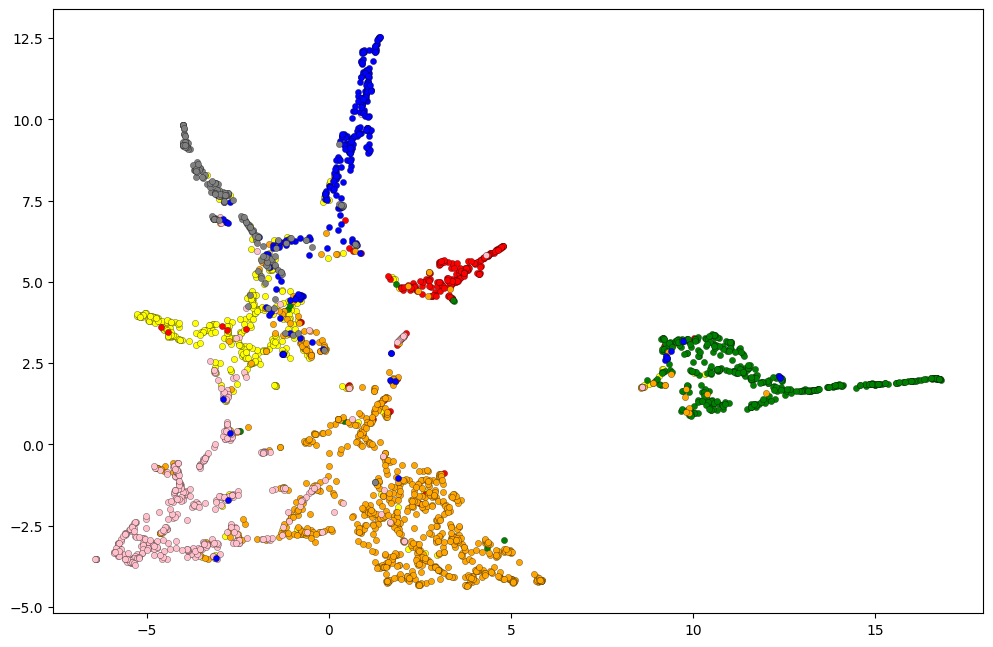

In [19]:
visualize_gat_properties(trainer_gat, visualization_type="umap")

Takođe jasno uočavamo sedam klastera. Rekli bismo da je UMAP u ovom konkretnom slučaju pogodniji za prikaz topologije podataka budući da su uočeni klasteri manjeg radijusa.

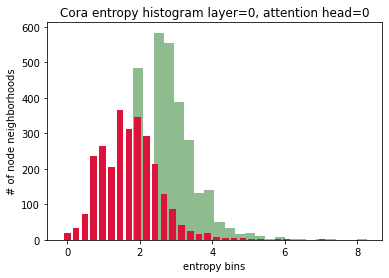

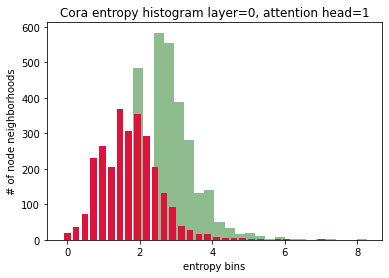

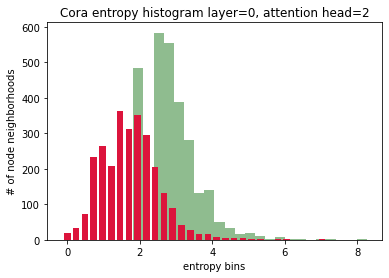

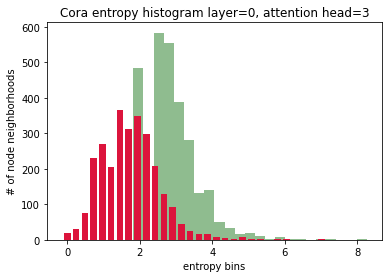

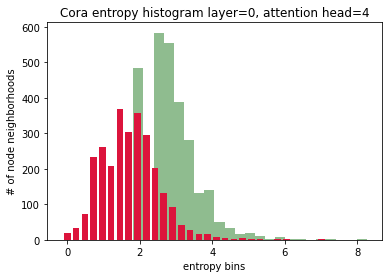

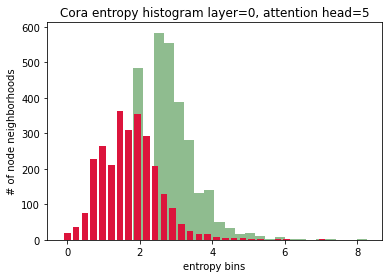

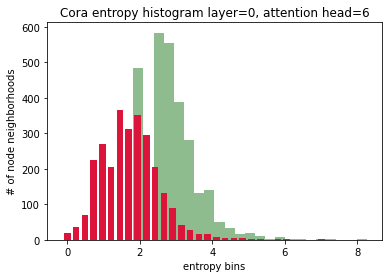

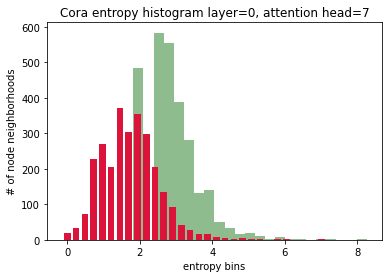

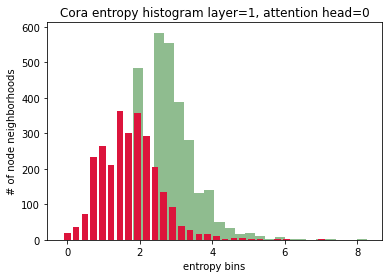

In [20]:
visualize_gat_properties(trainer_gat, visualization_type="entropy")

# Uticaj rezidualnih konekcija

Ispitaćemo uticaj rezidualnih konekcija u GAT arhitekturi. Istreniraćemo model sa istim hiperparametrima sa razlikom što su ovog puta rezidualne konekcije uključene. 

In [21]:
from copy import deepcopy

config_gat_skip = deepcopy(config_gat)
config_gat_skip["model_kwargs"]["add_skip_connection"] = True

trainer_gat_skip = Trainer(config_gat_skip)
trainer_gat_skip.run_training()

22-06-17 21:35:42: [INFO] epoch=[  1/200]: CE_train=1.94541 ACC_train=15.00%
22-06-17 21:35:43: [INFO] epoch=[  1/200]:   CE_val=1.94502   ACC_val=24.00%
22-06-17 21:35:43: [INFO] epoch=[  1/200]:  CE_test=1.94475  ACC_test=26.50%
22-06-17 21:35:44: [INFO] epoch=[  2/200]: CE_train=1.94337 ACC_train=35.71%
22-06-17 21:35:44: [INFO] epoch=[  3/200]: CE_train=1.93911 ACC_train=49.29%
22-06-17 21:35:45: [INFO] epoch=[  4/200]: CE_train=1.93340 ACC_train=66.43%
22-06-17 21:35:46: [INFO] epoch=[  5/200]: CE_train=1.92865 ACC_train=72.14%
22-06-17 21:35:47: [INFO] epoch=[  6/200]: CE_train=1.92301 ACC_train=62.14%
22-06-17 21:35:48: [INFO] epoch=[  7/200]: CE_train=1.91546 ACC_train=68.57%
22-06-17 21:35:48: [INFO] epoch=[  8/200]: CE_train=1.90632 ACC_train=75.00%
22-06-17 21:35:49: [INFO] epoch=[  9/200]: CE_train=1.89142 ACC_train=79.29%
22-06-17 21:35:50: [INFO] epoch=[ 10/200]: CE_train=1.88776 ACC_train=75.71%
22-06-17 21:35:50: [INFO] epoch=[ 10/200]:   CE_val=1.91114   ACC_val=66.20%

22-06-17 21:36:57: [INFO] epoch=[ 90/200]: CE_train=0.30658 ACC_train=96.43%
22-06-17 21:36:57: [INFO] epoch=[ 90/200]:   CE_val=0.91145   ACC_val=78.80%
22-06-17 21:36:58: [INFO] epoch=[ 90/200]:  CE_test=0.86700  ACC_test=81.10%
22-06-17 21:36:58: [INFO] epoch=[ 91/200]: CE_train=0.33265 ACC_train=97.14%
22-06-17 21:36:59: [INFO] epoch=[ 92/200]: CE_train=0.32717 ACC_train=94.29%
22-06-17 21:37:00: [INFO] epoch=[ 93/200]: CE_train=0.39074 ACC_train=94.29%
22-06-17 21:37:00: [INFO] epoch=[ 94/200]: CE_train=0.33123 ACC_train=92.86%
22-06-17 21:37:01: [INFO] epoch=[ 95/200]: CE_train=0.34804 ACC_train=94.29%
22-06-17 21:37:02: [INFO] epoch=[ 96/200]: CE_train=0.35057 ACC_train=92.86%
22-06-17 21:37:03: [INFO] epoch=[ 97/200]: CE_train=0.25124 ACC_train=97.86%
22-06-17 21:37:04: [INFO] epoch=[ 98/200]: CE_train=0.29030 ACC_train=97.14%
22-06-17 21:37:04: [INFO] epoch=[ 99/200]: CE_train=0.30096 ACC_train=95.00%
22-06-17 21:37:05: [INFO] epoch=[100/200]: CE_train=0.33343 ACC_train=95.00%

22-06-17 21:38:13: [INFO] epoch=[179/200]: CE_train=0.22872 ACC_train=98.57%
22-06-17 21:38:14: [INFO] epoch=[180/200]: CE_train=0.27921 ACC_train=95.00%
22-06-17 21:38:14: [INFO] epoch=[180/200]:   CE_val=0.84584   ACC_val=77.20%
22-06-17 21:38:15: [INFO] epoch=[180/200]:  CE_test=0.80609  ACC_test=80.20%
22-06-17 21:38:15: [INFO] epoch=[181/200]: CE_train=0.21916 ACC_train=96.43%
22-06-17 21:38:16: [INFO] epoch=[182/200]: CE_train=0.31830 ACC_train=94.29%
22-06-17 21:38:17: [INFO] epoch=[183/200]: CE_train=0.20241 ACC_train=97.14%
22-06-17 21:38:17: [INFO] epoch=[184/200]: CE_train=0.22809 ACC_train=97.14%
22-06-17 21:38:18: [INFO] epoch=[185/200]: CE_train=0.21758 ACC_train=98.57%
22-06-17 21:38:19: [INFO] epoch=[186/200]: CE_train=0.19895 ACC_train=97.86%
22-06-17 21:38:20: [INFO] epoch=[187/200]: CE_train=0.21561 ACC_train=94.29%
22-06-17 21:38:20: [INFO] epoch=[188/200]: CE_train=0.23195 ACC_train=97.14%
22-06-17 21:38:21: [INFO] epoch=[189/200]: CE_train=0.28549 ACC_train=94.29%

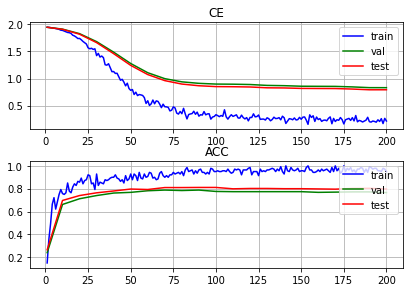

In [22]:
aggregator = trainer_gat_skip.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])

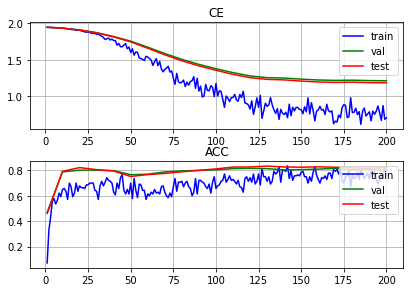

In [23]:
aggregator = trainer_gat.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])

Primećujemo da su rezidualne konekcije smanjile šum funkcije gubitka u toku treninga, ali su doprinele i višem stepenu preprilagođenja.